# Regressions

Regressions, in contrast to classification methods, allow the prediction of a point estimate and not only the prediction of a category. Going back to the eyesight example, one would not predict if an individual needs glasses or not but rather the thickness of the glasses. 
Regression analysis is a statistical method used in machine learning to predict a continuous outcome variable based on one or more predictor variables. Regression analysis aims to find the relationship between the predictor and outcome variables and use that relationship to make predictions. The essence of regression analysis is to find a mathematical equation that describes the relationship between the predictor and outcome variables and use that equation to make predictions. It is one of the most widely used techniques in machine learning and statistics, as it can be applied to many problems and easily interpreted.

Here we will work with a dataset that was part of a recent publication.

![alt text](./images/nhb_ds.jpg "Title")

The dataset includes data from German-native and -non-native readers. 
- `vp_code` ... Participant identifier
- `eyemovement_rate` ... Eye-movement rate in silent reading
- `speech_rate` ... Speed of speech
- `reading_speed` ... Reading speed measure from a screening
- `group` ... Native or Non-native German speaker

The goal of this example here is not to predict reading speed (`reading_speed`) from the other three measures. 

First, load the libraries, functions, and data we need for this example. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV

df = pd.read_csv("./datasets/data_eye_speech.csv")
df.head()

,vp_code,eyemovement_rate,speech_rate,reading_speed,group
0,001,4.876513,4.929337,45.454545,1
1,ABAFT17,5.029528,5.039975,83.116883,1
2,ACNMG09,5.299456,4.870547,57.142857,1
3,AKAFF09,4.690483,4.440987,64.935065,1
4,AMAMG16,5.067032,5.375254,63.636364,1


Next, let's start with a simple version of a regression model that fits a model with only one feature. In this case, we begin with `eyemovement_rate` as a feature for the prediction of `reading_speed`. 

In [2]:
X = df["eyemovement_rate"].values.reshape(-1, 1)
y = df["reading_speed"]

Then we define the regression method, in this case, a linear regression (i.e., `LinearRegression`) and the train-test split of the data. 

In [3]:
reg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Next, we fit the model and predict `reading_speed` based on the model and the training data. 

Now we have an observed and a predicted reading speed, which we can correlate to determine how similar the prediction is to the observed data. Remember, when the correlation coefficient is 1, they are highly similar. When the value is around 0, no similarity can be identified. Note that a negative correlation coefficient indicates an inverse relationship between two lists. 

In [4]:
reg.fit(X_train, y_train)
np.corrcoef(reg.predict(X_test),y_test)

array([[1.        , 0.42423387],
       [0.42423387, 1.        ]])

The correlation is medium in size. Meaning there is similarity, but there is also dissimilarity. 

We can also look at the mean squared error as a metric for how well the model fits the data. This metric describes the mean over all squared distances between a predicted value and the actual value. E.g., when the model predicts a reading score of 25, but the actual reading score of the person is 29, we have been off by 4 points. We underestimated the actual score in this case, so the difference is -4. When we now square this difference, the result is 16. Squaring this value has the reason to remove the sign. Thus an over or an underestimation of 4 points results in both in the value of 16. 

In [5]:
mse = mean_squared_error(reg.predict(X_train),y_train)
print("Mean squared error for the training set: {:.2f}".format(mse))

Mean squared error for the training set: 716.67


Next, we calculate the mean squared error in cross-validation with 5 folds. Note `cross_val_score` only gives back negative mean squared error values. Thus we multiply the scores with `-1`.

In [211]:
scores = cross_val_score(reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error")*-1
print("Cross-validation scores: {}".format(scores))
print("Average score: {:.2f}".format(scores.mean()))

Cross-validation scores: [616.33787808 836.7306192  902.57638806 806.17095301 620.61046553]
Average score: 756.49


In the final part, we estimate the quality of the prediction on the test dataset.

In [6]:
mse_test = mean_squared_error(reg.predict(X_test),y_test)
print("Mean squared error for the test set: {:.2f}".format(mse_test))

Mean squared error for the test set: 755.04


Based on the same logic learned for evaluating the categorization models, we can now assess the quality of the model based on the three metrics from training-, CV-, and test- data.

To get a better picture, we plot a scatterplot for the training and test data with the model represented as a regression line. 

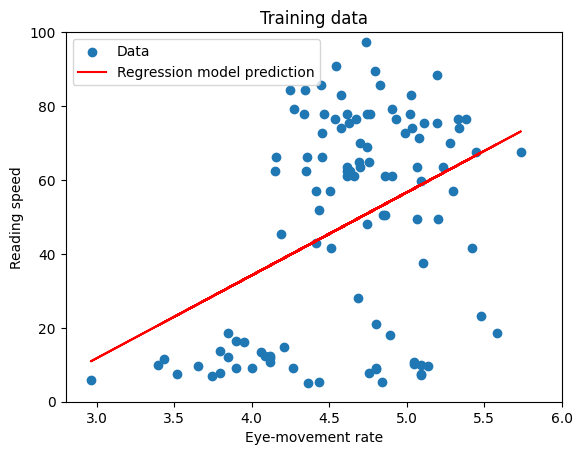

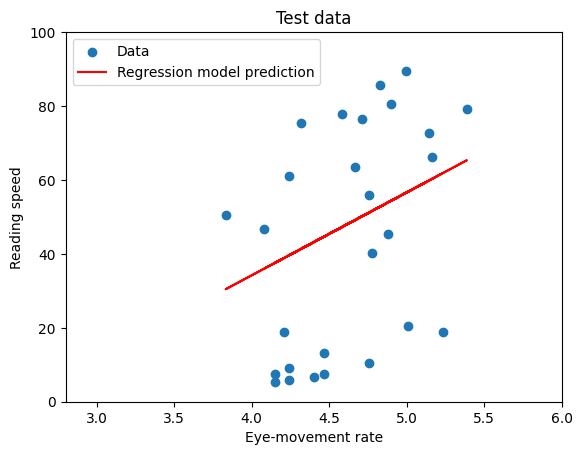

In [7]:
plt.scatter(X_train,y_train, label="Data")
plt.plot( X_train, reg.predict(X_train),color="r", label="Regression model prediction")
plt.legend()
plt.xlabel("Eye-movement rate")
plt.ylabel("Reading speed")
plt.title("Training data")
plt.xlim([2.8, 6])
plt.ylim([0, 100])
plt.show()

plt.scatter(X_test,y_test, label="Data")
plt.plot( X_test, reg.predict(X_test),color="r", label="Regression model prediction")
plt.legend()
plt.xlabel("Eye-movement rate")
plt.ylabel("Reading speed")
plt.title("Test data")
plt.xlim([2.8, 6])
plt.ylim([0, 100])
plt.show()

Overall the fit could be better. 


**Exercise** Fit a regression model to predict the reading speed based on the `speech_rate` and evaluate the model as above.

Next, we try to get a better model by adding new features. Here we now use the eye movement rate, speech rate, and group variable as features. 

To do this, we use the `drop` function from pandas and select the two variables that should not be part of the features. In this case, our target value, the `reading_speed`, and the participant indicator, which makes no sense to use as a feature `vp_code`. Also, categorical values cannot be used in a classical linear regression model. 

In [8]:
X = df.drop(["reading_speed","vp_code"], axis=1)

Next, we again fit and evaluate the model. 

In [9]:
reg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

reg = LinearRegression()
reg.fit(X_train, y_train)
np.corrcoef(reg.predict(X_test),y_test)

array([[1.        , 0.87480071],
       [0.87480071, 1.        ]])

In contrast to the previous models, the correlation is now very high. This might be the first indication that the model fit is much better. 

In [10]:
mse = mean_squared_error(reg.predict(X_train),y_train)
print("Mean squared error for the training set: {:.2f}".format(mse))

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error")*-1
print("Cross-validation scores: {}".format(scores))
print("Average score: {:.2f}".format(scores.mean()))

mse_test = mean_squared_error(reg.predict(X_test),y_test)
print("Mean squared error for the test set: {:.2f}".format(mse_test))

Mean squared error for the training set: 120.10
Cross-validation scores: [157.45712843 160.88894094  42.20080662 164.4938338  146.56016848]
Average score: 134.32
Mean squared error for the test set: 210.82


As already assumed by the correlation, we also find much lower mean squared error values. 

**Exercise** Show a figure with a regression line as above. 

In [ ]:
-

**Feature Selection**

So taking all features gives us the best model, but is this a good strategy? Clearly no.
Here are some reasons why it is essential to keep the number of features at optimal number is critical for several reasons:
- Simplicity and interpretability: Having too many features can make the model more complex and easier to interpret.
- Overfitting: Too many features can lead to overfitting as the likelihood of fitting a noise component increases.
- Computational efficiency
Thus keeping the number of features in machine learning at an optimal number is beneficial. 

Next, we reduce the number of parameters to an optimum. A first indicator could be again the correlations between the features. 

In [11]:
df.corr()

,eyemovement_rate,speech_rate,reading_speed,group
eyemovement_rate,1.000000,0.306936,0.398437,0.400984
speech_rate,0.306936,1.000000,0.469060,0.444221
reading_speed,0.398437,0.469060,1.000000,0.913871
group,0.400984,0.444221,0.913871,1.000000


Here we already see that the one feature, i.e., the `group` variable, is highly correlated with our outcome measure `reading_speed`.

One can also use methods like `RFE` (i.e., Recursive Feature Elimination) to find the optimal set of features. Here we want to find the optimal set of features for our LinearRegression model. RFE is a feature selection method that recursively removes features and then builds a model using the remaining ones. Model accuracy is used to identify which feature combination contributes to an accurate prediction. 

Here we use the `RFE` version that already includes cross-validation (`RFECV`).

In [12]:
model = LinearRegression()
rfecv = RFECV(model, cv=5)
rfecv.fit(X, y)

RFECV(cv=5, estimator=LinearRegression())

After fitting we can now look at the number of features and the name of the features. 

In [13]:
print("Optimal number of features: ", rfecv.n_features_)
print("Optimal features: ", X.columns[rfecv.support_])

Optimal number of features:  1
Optimal features:  Index(['group'], dtype='object')


As the correlations suggest, the model with only the group features has the optimal number and type of features. 

**Exercise** Find the optimal set of parameters when we do not include the `group` feature. Use also, instead of a linear regression, the ridge regression method (`Ridge()`)

In [14]:
X = df.drop(["reading_speed","vp_code","group"], axis=1)
model = Ridge()
rfecv = RFECV(model, cv=5)
rfecv.fit(X, y)
print("Optimal number of features: ", rfecv.n_features_)
print("Optimal features: ", X.columns[rfecv.support_])

Optimal number of features:  2
Optimal features:  Index(['eyemovement_rate', 'speech_rate'], dtype='object')
